In [10]:
import numpy as np
import matplotlib.pyplot as plt
import utils
from sklearn.decomposition import PCA
from gridworld import SimpleGrid

%matplotlib inline

cmap = plt.cm.viridis
cmap.set_bad(color='white')

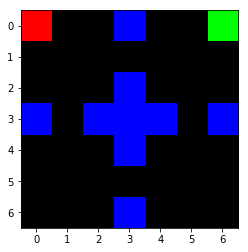

In [11]:
grid_size = 7
pattern="four_rooms"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")
env.reset(agent_pos=[0,0], goal_pos=[0, grid_size-1])
plt.imshow(env.grid)

In [20]:
class TabularSuccessorAgent(object):
    def __init__(self, state_size, action_size, learning_rate, gamma):
        self.state_size = state_size
        self.action_size = action_size
        self.M = np.stack([np.identity(state_size) for i in range(action_size)])
        self.M_s = np.identity(state_size)
        self.w = np.zeros([state_size])
        self.learning_rate = learning_rate
        self.gamma = gamma
        
    def Q_estimates(self, state, goal=None):
        # Generate Q values for all actions.
        if goal == None:
            goal = self.w
        else:
            goal = utils.onehot(goal, self.state_size)
        return np.matmul(self.M[:,state,:],goal)
    
    def sample_action(self, state, goal=None, epsilon=0.0):
        # Samples action using epsilon-greedy approach
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(self.action_size)
        else:
            Qs = self.Q_estimates(state, goal)
            action = np.argmax(Qs)
        return action
    
    def update_w(self, current_exp):
        # A simple update rule (for reward learning?)
        s_1 = current_exp[2]
        r = current_exp[3]
        error = r - self.w[s_1]
        self.w[s_1] += self.learning_rate * error        
        return error
    
    
    def update_actor(state_action_matrix, observation, action, delta, beta_matrix=None):
        '''
        Return the updated state-action matrix
        @param state_action_matrix the matrix before the update
        @param observation the state obsrved at t
        @param action taken at time t
        @param delta the estimation error returned by the critic
        @param beta_matrix a visit counter for each state-action pair
        @return the updated matrix
        '''
        col = observation[1] + (observation[0]*4)
        if beta_matrix is None: beta = 1
        else: beta = 1 / beta_matrix[action,col]
        state_action_matrix[action, col] += beta * delta
        return state_action_matrix 


    def update_sr2(self,current_exp,next_exp):
        s = current_exp[0]
        s_1 = current_exp[2]
        r = current_exp[3]
        d = current_exp[4]
        I = utils.onehot(s, env.state_size)
        if d:            
            td_error = (I + self.gamma * utils.onehot(s_1, env.state_size) - self.M_s[ s, :])
        else:
            td_error = (I + self.gamma * self.M_s[s_1, :] - self.M_s[s, :])
            #print (td_error)
        self.M_s[s, :] += self.learning_rate * td_error
        
        return td_error
    def update_sr(self, current_exp, next_exp):
        # SARSA TD learning rule
        s = current_exp[0]
        s_a = current_exp[1]
        s_1 = current_exp[2]
        s_a_1 = next_exp[1]
        r = current_exp[3]
        d = current_exp[4]
        I = utils.onehot(s, env.state_size)
        if d:            
            td_error = (I + self.gamma * utils.onehot(s_1, env.state_size) - self.M[s_a, s, :])
        else:
            td_error = (I + self.gamma * self.M[s_a_1, s_1, :] - self.M[s_a, s, :])
        self.M[s_a, s, :] += self.learning_rate * td_error
        
        return td_error

In [18]:
agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)
print(np.shape(agent.M))
print (np.shape(agent.M[0]))

(4, 49, 49)
(49, 49)


Text(0.5, 1.0, 'Episode Lengths')

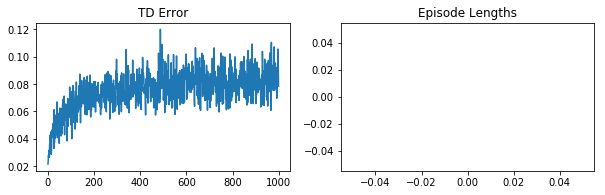

In [29]:
train_episode_length = 50
test_episode_length = 50
episodes = 1000
gamma = 0.95
lr = 5e-2
train_epsilon = 1.0
test_epsilon = 0.1


# instantiating grid
agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

experiences = []
test_experiences = []
test_lengths = []
lifetime_td_errors = []


for i in range(episodes):
    # Train phase
    agent_start = [0,0]
    
    # for now having a single goal pos
    goal_pos = [0, grid_size-1]
    '''
    if i < episodes // 2: #Integer division
        goal_pos = [0, grid_size-1]
    else:
        if i == episodes // 2:
            print("\nSwitched reward locations")
        goal_pos = [grid_size-1,grid_size-1]
    '''
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    episodic_error = []
    for j in range(train_episode_length):
        
        #instead of sampling action, implement actor here
        action = agent.sample_action(state, epsilon=train_epsilon)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])
        state = state_next
        if (j > 1):
            td_sr = agent.update_sr2(experiences[-2], experiences[-1])
            td_w = agent.update_w(experiences[-1])
            # storing episodic errors
            episodic_error.append(np.mean(np.abs(td_sr)))
        if env.done:
            td_sr = agent.update_sr2(experiences[-1], experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
            break
    lifetime_td_errors.append(np.mean(episodic_error))
    '''
    # Test phase
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    for j in range(test_episode_length):
        action = agent.sample_action(state, epsilon=test_epsilon)
        reward = env.step(action)
        state_next = env.observation
        test_experiences.append([state, action, state_next, reward])
        state = state_next
        if env.done:
            break
    test_lengths.append(j)
    
    if i % 50 == 0:
        print('\rEpisode {}/{}, TD Error: {}, Test Lengths: {}'
              .format(i, episodes, np.mean(lifetime_td_errors[-50:]), 
                      np.mean(test_lengths[-50:])), end='')
    '''

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lifetime_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(test_lengths)
ax.set_title("Episode Lengths")


In [24]:
print (lifetime_td_errors[1999])

0.09954242135870627


In [23]:
def print_occupancy(experiences, grid_size):
    occupancy_grid = np.zeros([grid_size, grid_size])
    for experience in experiences:
        occupancy_grid += env.state_to_grid(experience[0])
    occupancy_grid = np.sqrt(occupancy_grid)
    occupancy_grid = utils.mask_grid(occupancy_grid, env.blocks)
    plt.imshow(occupancy_grid)

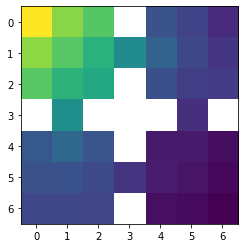

In [24]:
print_occupancy(experiences, grid_size)

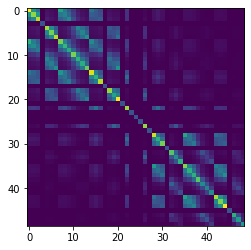

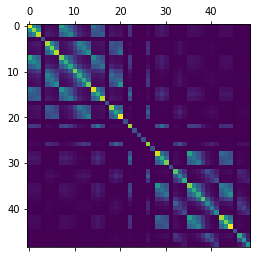

In [33]:
#averaged_M = np.mean(agent.M_s)
plt.imshow(agent.M_s)

IndexError: tuple index out of range

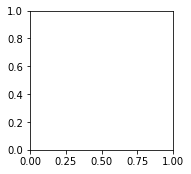

In [32]:
#averaged_M = np.reshape(averaged_M, [env.state_size, grid_size, grid_size])

cmap = plt.cm.viridis
cmap.set_bad(color='white')

plt.figure(1, figsize=(grid_size*3, grid_size*3))
for i in range(env.state_size):
    if env.state_to_point(i) not in env.blocks:
        ax = plt.subplot(grid_size, grid_size, i + 1)
        #ax.imshow(utils.mask_grid(averaged_M[i,:,:], env.blocks), cmap=cmap)
        ax.imshow(utils.mask_grid(agent.M_s[i,:], env.blocks), cmap=cmap)

##  SR Actor Critic

The following section explores creating a separated actor critic architecture

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import utils
from sklearn.decomposition import PCA
from gridworld import SimpleGrid

%matplotlib inline

cmap = plt.cm.viridis
cmap.set_bad(color='white')

In [38]:
def softmax(x):
    '''Compute softmax values of array x.

    @param x the input array
    @return the softmax array
    '''
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

def update_critic(utility_matrix, observation, new_observation, 
                   reward, alpha, gamma, done):
    '''Return the updated utility matrix

    @param utility_matrix the matrix before the update
    @param observation the state obsrved at t
    @param new_observation the state observed at t+1
    @param reward the reward observed after the action
    @param alpha the step size (learning rate)
    @param gamma the discount factor
    @return the updated utility matrix
    @return the estimation error delta
    '''
    u = utility_matrix[observation[0], observation[1]]
    u_t1 = utility_matrix[new_observation[0], new_observation[1]]
    delta = reward + ((gamma * u_t1) - u)
    utility_matrix[observation[0], observation[1]] += alpha * delta
    return utility_matrix, delta


def update_actor(state_action_matrix, observation, action, delta, beta_matrix=None):
    '''Return the updated state-action matrix

    @param state_action_matrix the matrix before the update
    @param observation the state obsrved at t
    @param action taken at time t
    @param delta the estimation error returned by the critic
    @param beta_matrix a visit counter for each state-action pair
    @return the updated matrix
    '''
    col = observation[1] + (observation[0]*4)
    if beta_matrix is None: beta = 1
    else: beta = 1 / beta_matrix[action,col]
    state_action_matrix[action, col] += beta * delta
    return state_action_matrix 


In [ ]:
def main():
    
    
    train_episode_length = 50
    test_episode_length = 50
    episodes = 2000
    gamma = 0.95
    lr = 5e-2
    train_epsilon = 1.0
    test_epsilon = 0.1


    # instantiating grid
    agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

    experiences = []
    test_experiences = []
    test_lengths = []
    lifetime_td_errors = []
    '''
    env = GridWorld(3, 4)

    #Define the state matrix
    state_matrix = np.zeros((3,4))
    state_matrix[0, 3] = 1
    state_matrix[1, 3] = 1
    state_matrix[1, 1] = -1
    print("State Matrix:")
    print(state_matrix)
    '''
    
    #Define the reward matrix
    reward_matrix = np.full((3,4), -0.04)
    reward_matrix[0, 3] = 1
    reward_matrix[1, 3] = -1
    print("Reward Matrix:")
    print(reward_matrix)
    
    
    '''
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])

    state_action_matrix = np.random.random((4,12))
    print("State-Action Matrix:")
    print(state_action_matrix)
    

    env.setStateMatrix(state_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
   
    utility_matrix = np.zeros((3,4))
    print("Utility Matrix:")
    print(utility_matrix)
    '''
    gamma = 0.999
    alpha = 0.001 #constant step size
    beta_matrix = np.zeros((4,12)) #related to action learning, ow though? policy?
    tot_epoch = 300000
    print_epoch = 1000

    for epoch in range(tot_epoch):
        #Reset and return the first observation
        observation = env.reset(exploring_starts=True)
        for step in range(1000):
            #Estimating the action through Softmax
            col = observation[1] + (observation[0]*4)
            action_array = state_action_matrix[:, col]
            action_distribution = softmax(action_array)
            action = np.random.choice(4, 1, p=action_distribution) #pick an action based on probability
            #To enable the beta parameter, enable the libe below
            #and add beta_matrix=beta_matrix in the update actor function
            #beta_matrix[action,col] += 1 #increment the counter
            #Move one step in the environment and get obs and reward
            new_observation, reward, done = env.step(action)
            utility_matrix, delta = update_critic(utility_matrix, observation, 
                                                  new_observation, reward, alpha, gamma, done)
            state_action_matrix = update_actor(state_action_matrix, observation, 
                                               action, delta, beta_matrix=None)
            observation = new_observation
            if done: break
            

        if(epoch % print_epoch == 0):
            print("")
            print("Utility matrix after " + str(epoch+1) + " iterations:") 
            print(utility_matrix)
            print("")
            print("State-Action matrix after " + str(epoch+1) + " iterations:") 
            print(state_action_matrix)
    #Time to check the utility matrix obtained
    print("Utility matrix after " + str(tot_epoch) + " iterations:")
    print(utility_matrix)
    print("State-Action matrix after  " + str(tot_epoch) + " iterations:")
    print(state_action_matrix)
    print(reward_matrix)


if __name__ == "__main__":
    main()
